In [ ]:
#%matplotlib qt
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim

In [ ]:
gdf = gpd.read_file('tl_2021_us_county.zip')

In [ ]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [ ]:
gdf = gdf[gdf.STATEFP=='42']  # select CA

In [ ]:
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
19,42,007,01214112,42007,Beaver,Beaver County,06,H1,G4020,430,38300,None,A,1125854819,24162295,+40.6841401,-080.3507209,"POLYGON ((-80.27803 40.53674, -80.29151 40.527..."
47,42,053,01213669,42053,Forest,Forest County,06,H1,G4020,None,None,None,A,1106595595,8369675,+41.5133040,-079.2497050,"POLYGON ((-78.95860 41.52549, -78.95861 41.525..."
95,42,117,01209189,42117,Tioga,Tioga County,06,H1,G4020,None,None,None,A,2936765818,8279717,+41.7668593,-077.2572881,"POLYGON ((-77.21159 41.54545, -77.21177 41.545..."
108,42,043,01213667,42043,Dauphin,Dauphin County,06,H1,G4020,276,25420,None,A,1359407363,86209037,+40.4125646,-076.7926343,"POLYGON ((-76.59217 40.25428, -76.59214 40.254..."
165,42,127,01213692,42127,Wayne,Wayne County,06,H1,G4020,None,None,None,A,1879734030,64785676,+41.6466021,-075.2924932,"POLYGON ((-75.29834 41.36740, -75.29849 41.367..."


# Convenience function to add some commonly used attributes

* *GeoSeries.area* just returns the area
* See [GeoSeries.representative_point](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.representative_point.html) . The end result is that the __coords__ column contains a point within the boundaries of the region.

In [ ]:
def add_area_and_label_coords(some_gdf):
    some_gdf['area'] = some_gdf.area
    some_gdf['coords'] = some_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    some_gdf['coords'] = [coords[0] for coords in some_gdf['coords']]

# A convenience function to do labeled maps and choropleths

In [ ]:
def plot_with_labels(some_gdf, ax, name_col=None, field_col=None, **kwargs):
    if field_col is None:
        some_gdf.plot(ax=ax, **kwargs)
    else:
        some_gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    if name_col is not None:
        for idx, row in some_gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row['coords'],
                         horizontalalignment='center')

In [ ]:
def calc_overall_centroid(some_gdf):
    """
    Use the 'coords' and 'area' columns to estimate an overall centroid
    """
    sum_x = 0.0
    sum_y = 0.0
    sum_area = 0.0
    for idx, row in some_gdf.iterrows():
        coord_x, coord_y = row['coords']
        sum_x += coord_x * row['area']
        sum_y += coord_y * row['area']
        sum_area += row['area']
    centroid_x = sum_x / sum_area
    centroid_y = sum_y / sum_area
    return centroid_x, centroid_y

In [ ]:
add_area_and_label_coords(gdf)
centroid_x, centroid_y = calc_overall_centroid(gdf)
print(centroid_x, centroid_y)

-77.84058346055701 40.900430189750736


<ipython-input-52-826e582dea62>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area


Text(0.5, 0.98, 'Original CRS')

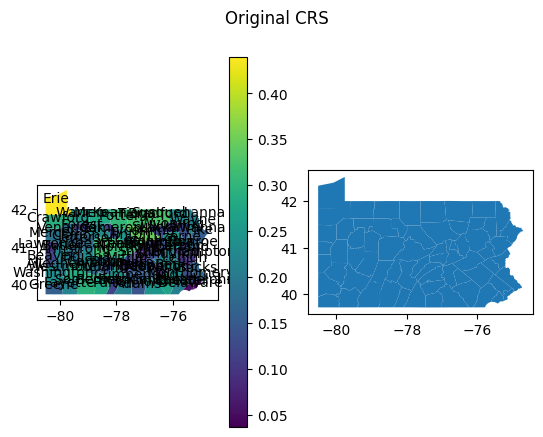

In [ ]:
fig, axes = plt.subplots(1,2)
plot_with_labels(gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(gdf, ax=axes[1])
fig.suptitle('Original CRS')

# This is the CRS of the data when we read it in

In [ ]:
gdf.crs


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

# Orthographic projection centered on our centroid
See [Orthographic projection with pyproj for penguin tracking in Antarctica](https://towardsdatascience.com/orthographic-projection-with-pyproj-for-penguin-tracking-in-antarctica-18cd2bf2d570) for the trick.

In [ ]:
lat = centroid_y
lon = centroid_x
ortho = CRS.from_proj4("+proj=ortho +lat_0={} +lon_0={} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs".format(lat, lon))

Convert the coordinates to this new CRS

In [ ]:
ortho_gdf = gdf.to_crs(ortho)
ortho_gdf.crs

<Projected CRS: +proj=ortho +lat_0=40.900430189750736 +lon_0=-77.8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Orthographic
Datum: Unknown based on Normal Sphere (r=6370997) ellipsoid
- Ellipsoid: Normal Sphere (r=6370997)
- Prime Meridian: Greenwich

Text(0.5, 0.98, 'Ortho')

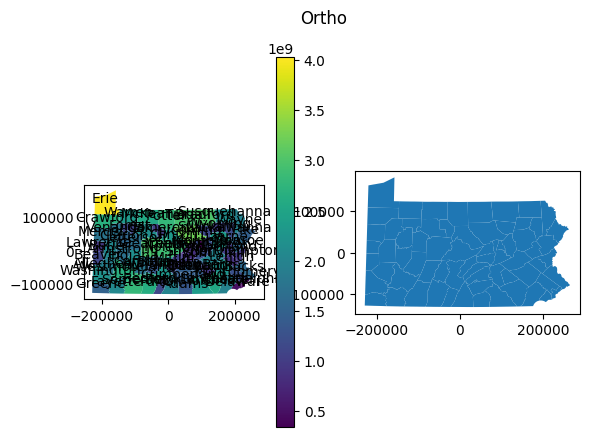

In [ ]:
add_area_and_label_coords(ortho_gdf)
fig, axes = plt.subplots(1,2)
plot_with_labels(ortho_gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(ortho_gdf, ax=axes[1])
fig.suptitle('Ortho')

# Repeat with Universal Transverse Mercator
because it is commonly used

In [ ]:
utm_proj = CRS.from_proj4("+proj=utm +zone=10 +north")
print(utm_proj)

+proj=utm +zone=10 +north +type=crs


In [ ]:
utm_gdf = gdf.to_crs(utm_proj)
utm_gdf.crs

<Projected CRS: +proj=utm +zone=10 +north +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 0.98, 'Universal Transverse Mercator Zone 10 North')

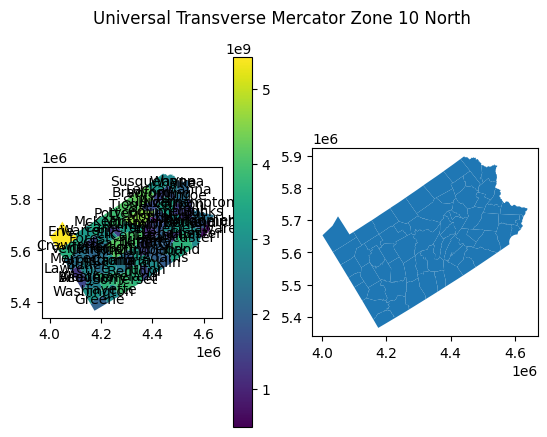

In [ ]:
add_area_and_label_coords(utm_gdf)
fig, axes = plt.subplots(1,2)
plot_with_labels(utm_gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(utm_gdf, ax=axes[1])
fig.suptitle('Universal Transverse Mercator Zone 10 North')

# For contrast, let's try a CRS for an inappropriately chosen region:
[EPSG:32633](https://epsg.io/32633)

In [ ]:
new_gdf = gdf.to_crs("EPSG:32633")

In [ ]:
new_gdf.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 0.98, 'Universal Transverse Mercator Zone 33N')

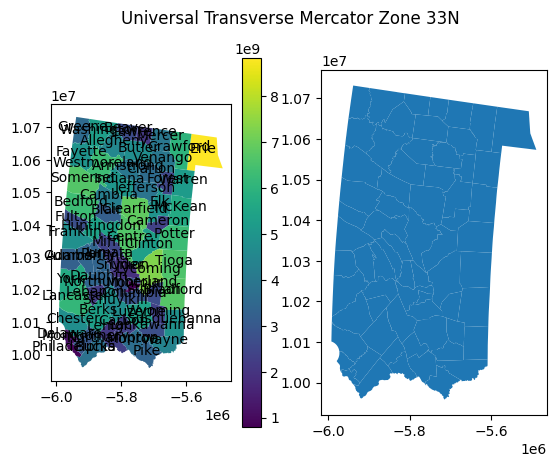

In [ ]:
add_area_and_label_coords(new_gdf)
fig, axes = plt.subplots(1,2)
plot_with_labels(new_gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(new_gdf, ax=axes[1])
fig.suptitle('Universal Transverse Mercator Zone 33N')

# Now let's look at FIPS codes

In [ ]:
fips_gdf = gpd.read_file('tl_2021_us_county.shp')
display(fips_gdf.columns)
fips_gdf = fips_gdf[fips_gdf.STATEFP=='42']  # select PA
add_area_and_label_coords(fips_gdf)

ERROR:fiona._env:Unable to open tl_2021_us_county.shx or tl_2021_us_county.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


DriverError: Unable to open tl_2021_us_county.shx or tl_2021_us_county.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

Make some label strings combining state and county FIPS codes

In [ ]:
def build_fips_string(row):
    return f"{row['STATEFP']}{row['COUNTYFP']}"
fips_gdf['fips_string'] = fips_gdf.apply(build_fips_string, axis=1)
fips_gdf.head()

In [ ]:
fig, axes = plt.subplots(2,1)
plot_with_labels(fips_gdf, name_col='NAME', ax=axes[0])
plot_with_labels(fips_gdf, name_col='fips_string', ax=axes[1])


# Now some geopy examples

In [ ]:
geolocator = Nominatim(user_agent="ms_das_vis")
location = geolocator.geocode("425 South Craig St., Pittsburgh")
print(f'address: {location.address}')
print(f'point: {location.point}')
#print(f'raw: {location.raw}')
print(f'altitude: {location.altitude}')
print(f'latitude: {location.latitude}')
print(f'longitude: {location.longitude}')

In [ ]:
geolocator.reverse((40.44501531264918, -79.94863300565322), exactly_one=False)  # (latitude, longitude)

## We can get distances and travel times as well
But we need to explicitly handle some HTTP requests for this part.

In [ ]:
import requests
import urllib
import datetime
from pprint import pprint

In [ ]:
geolocator = Nominatim(user_agent="ms_das_vis")
addr1 = "425 South Craig St., Pittsburgh, PA"
addr2 = "6304 Forbes Ave., Pittsburgh, PA"
loc1 = geolocator.geocode(addr1)
loc2 = geolocator.geocode(addr2)

In [ ]:
response = requests.get('http://router.project-osrm.org/route/v1/driving/'
                        + f'{loc1.longitude},{loc1.latitude};{loc2.longitude},{loc2.latitude}'
                       )

In [ ]:
response.status_code

In [ ]:
response.json()

Travel distance is in meters, duration in seconds.

# You can use Google Maps, *if* you have an API key.

In [ ]:
time_now = datetime.datetime.now(datetime.timezone.utc)
time_epoch = datetime.datetime(1970, 1, 1, tzinfo=datetime.timezone.utc)  # Unix epoch
target_timestamp = (time_now - time_epoch).total_seconds()

In [ ]:
query = {
    "arrival_time": int(target_timestamp),
    "origins": f"{loc1.latitude},{loc1.longitude}",
    "destinations": f"{loc2.latitude},{loc2.longitude}"
}

pprint(query)

response = requests.get('http://maps.googleapis.com/maps/api/distancematrix/json?'
                        + urllib.parse.urlencode(query))
print(response)
print(response.json())